In [24]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from imblearn.ensemble import EasyEnsembleClassifier

import re

from urlextract import URLExtract

from scipy.sparse import hstack

import numpy as np

import json

import pickle

import sys

import seaborn as sns

sys.path.append('..')
from src.features.build_features import syns, sep_urls, check_paren, repo_label
from src.data.make_dataset import return_passages, test_suitability

In this notebook, I'm bolting on a second level classifier to see how things work out. The first time around doing this, I did things a little wonky. The next commit for this notebook will clean that up

In [4]:
def code_kw(text):
    passage_marked = 0
    
    reg_matches = re.compile(r"""(software)|(tool)|(code)|(package)|(\sR\s)|(python)|
                                 (matlab)|(SPM8)|(implement.)""", re.X|re.VERBOSE)
    
    m = re.search(reg_matches, text.lower())
    if m:
        return(1)
    else:
        return(0)

Here, we're looking at the results of labeling the data

In [5]:
df_labeled = pd.read_csv('/data/riddleta/data_sharing_reuse/interim/high_recall_labelling - high_recall_labelling.csv')

In [6]:
df_labeled['recoded_labels'] = df_labeled.n2.replace({'c':0, 'n':0, '2':1, 'd':1, 'n2':0, 'nd':0})

In [7]:
df_labeled.recoded_labels.value_counts()

0    341
1    159
Name: recoded_labels, dtype: int64

In [8]:
df_labeled['kw_code'] = df_labeled.text.apply(lambda x: code_kw(x))

In [9]:
pd.crosstab(df_labeled.kw_code, df_labeled.n2)

n2,2,c,d,n,n2,nd
kw_code,,,,,,
0,88,58,50,133,12,6
1,7,112,14,20,0,0


In [10]:
df_labeled.n2.value_counts()

c     170
n     153
2      95
d      64
n2     12
nd      6
Name: n2, dtype: int64

Now we rerun the classifier on the original training sample (before the new labels)

In [13]:
extract = URLExtract()
df = pd.read_csv('/data/riddleta/data_sharing_reuse/external/combined_labels_incomplete.csv')
df.text.fillna('', inplace=True)
df['has_url'] = df.text.apply(lambda x: extract.has_urls(x))
df['has_parenth'] = df.text.apply(lambda x: check_paren(x))
df['repo'] = df.text.apply(lambda x: repo_label(x))
df['text'] = df.text.apply(lambda x: sep_urls(x))
df['syn_text'] = df.text.apply(lambda x: syns(x))
df['all_text'] = df.text + ' ' + df.syn_text

In [14]:
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

x_tr, x_tst, y_tr, y_tst = train_test_split(df.all_text, df.data_statement, test_size=.25, random_state=42, stratify=df.data_statement)

In [15]:
x_train = cv.fit_transform(x_tr)
one_hots_train = enc.fit_transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].loc[x_tr.index])
y_train = df.data_statement[x_tr.index]
x_test = cv.transform(df.all_text[x_tst.index])
one_hots_test = enc.transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[x_tst.index])
y_test = df.data_statement[x_tst.index]

x_train = hstack([x_train, one_hots_train])
x_test = hstack([x_test, one_hots_test])
#x_res, y_res = ros.fit_resample(x_train, y_train)

clf = EasyEnsembleClassifier()
y_score = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted    0   1
True              
0          551  30
1            3  50
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       581
           1       0.62      0.94      0.75        53

    accuracy                           0.95       634
   macro avg       0.81      0.95      0.86       634
weighted avg       0.96      0.95      0.95       634



Now add in the new labels. The second level classifier is going to use predicted probabilities from the first, so we're going to switch to a 3-fold cross validation scheme, using the predicted probabilities for the held out fold as the input for the next level.

In [16]:
df_labeled['data_statement'] = df_labeled.n2.replace({'c':0, 'n':0, '2':1, 
                                                      'd':1, 'n2':0, 'nd':0})
df = pd.read_csv('/data/riddleta/data_sharing_reuse/external/combined_labels_incomplete.csv')
df = pd.concat([df[['text', 'section', 'doi', 'Journal Title', 
                   'pmcid', 'data_statement']],
              df_labeled[['text', 'section', 'doi', 'Journal Title', 
                          'pmcid', 'data_statement']]])
df.text.fillna('', inplace=True)
df.shape

(3033, 6)

In [17]:
df_nimh = pd.read_csv('/data/riddleta/data_sharing_reuse/external/nimh_papers.csv')
df_nimh['Year'] = df_nimh['journal_year']
df_nimh = df_nimh[['pmcid', 'Year']].drop_duplicates()
df = df.merge(df_nimh, how='left', on='pmcid')
df['has_url'] = df.text.apply(lambda x: extract.has_urls(x))
df['has_parenth'] = df.text.apply(lambda x: check_paren(x))
df['repo'] = df.text.apply(lambda x: repo_label(x))
df['text'] = df.text.apply(lambda x: sep_urls(x))
df['syn_text'] = df.text.apply(lambda x: syns(x))
df['all_text'] = df.text + ' ' + df.syn_text

In [33]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

df['pred_prob'] = 0

for train_index, test_index in kfold.split(df.all_text, df.data_statement):
    x_train = cv.fit_transform(df.all_text[train_index])
    one_hots_train = enc.fit_transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[train_index])
    y_train = df.data_statement[train_index]
    x_test = cv.transform(df.all_text[test_index])
    one_hots_test = enc.transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[test_index])
    y_test = df.data_statement[test_index]
    
    x_train = hstack([x_train, one_hots_train])
    x_test = hstack([x_test, one_hots_test])
    
    clf = EasyEnsembleClassifier()
    y_score = clf.fit(x_train, y_train)
    df['pred_prob'].loc[test_index] = clf.predict_proba(x_test)[:,1]

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

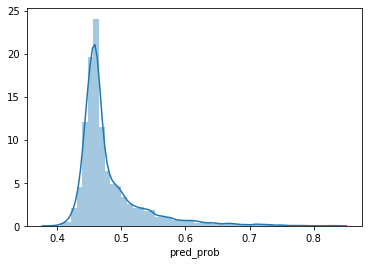

In [34]:
sns.distplot(df.pred_prob)

In [38]:
df['kw_code'] = df.text.apply(lambda x: code_kw(x))
df['interaction'] = df.kw_code * df.pred_prob
x_tr, x_tst, y_tr, y_tst = train_test_split(df.kw_code, df.data_statement, test_size=.33, random_state=42, stratify=df.data_statement)
x_tr = df[['kw_code', 'pred_prob', 'interaction']].loc[x_tr.index]
x_tst = df[['kw_code', 'pred_prob', 'interaction']].loc[x_tst.index]

clf_log = LogisticRegression(random_state=42)
clf_log.fit(x_tr, y_tr)
y_pred = clf_log.predict(x_tst)
print(pd.crosstab(y_tst, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_tst, y_pred))

Predicted    0   1
True              
0          878   1
1          104  18
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       879
           1       0.95      0.15      0.26       122

    accuracy                           0.90      1001
   macro avg       0.92      0.57      0.60      1001
weighted avg       0.90      0.90      0.86      1001



## below here is appendix code

after this, I'm using the high-recall classifier to apply labels to the population of papers. I didn't really do much with this, other than inspect the results.

In [34]:
nimh_papers = pd.read_csv('/data/riddleta/data_sharing_reuse/external/nimh_papers.csv')
#load file index
file_ix = pd.read_csv('/data/riddleta/data_sharing_reuse/external/file_index.csv')
file_ix['pmcid'] = file_ix.pmcid.astype('str')
nimh_papers['pmcid'] = nimh_papers.pmcid.astype('str')

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
target_papers = file_ix[file_ix.pmcid.isin(nimh_papers.pmcid)]
target_papers.shape
target_papers = target_papers.sort_values('file')
status_prints = range(0, len(target_papers.file.tolist()), 250)
len(status_prints)

231

In [40]:
data_collect = []
last_file = np.nan
for i, file in enumerate(target_papers.file.tolist()):
    if i in status_prints:
        print(i)
    if file == last_file:
        paper = dat[target_papers.paper_number.iloc[i]]
        out_dat = return_passages(paper)
        data_collect.extend(out_dat)
    else:
        with open(file) as infile:
            dat = json.load(infile)
            paper = dat[target_papers.paper_number.iloc[i]]
            out_dat = return_passages(paper)
            data_collect.extend(out_dat)
            last_file = file

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
20500
20750
21000
21250
21500
21750
22000
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000
25250
25500
25750
26000
26250
26500
26750
27000
27250
27500
27750
28000
28250
28500
28750
29000
29250
29500
29750
30000
30250
30500
30750
31000
31250
31500
31750
32000
32250
32500
32750
33000
33250
33500
33750
34000
34250
34500
34750
35000
35250
35500
35750
36000
36250
36500
36750
37000
37250
37500
37750
38000
38250
38500
38750
39000
39250
39500
39750
40000
40250
40500
40750
41000
41250
41500
41750
42000
42250
42500
42750
43000
43250
43

In [43]:
df_pool = pd.DataFrame(data_collect)
df_pool.columns = ['context', 'paper_offset', 'pmcid', 'doi', 'section']
tk_file = open('/data/riddleta/data_sharing_reuse/external/tokenizer.pk', 'rb')
tokenizer = pickle.load(tk_file)
tk_file.close()
df_pool['context'] = df_pool.context.apply(lambda x: tokenizer.tokenize(x))
df_pool = df_pool.explode('context')
df_pool.shape# all sentence 18406892

(18406892, 5)

In [44]:
df_pool = df_pool[~df_pool.section.isin(['REF', 'TABLE', 'TITLE'])]
df_pmcids = pd.read_csv('/data/riddleta/data_sharing_reuse/external/PMC-ids.csv')
df_pmcids['pmcid'] = df_pmcids.PMCID.apply(lambda x: str(x)[3:])
df_pool = df_pool.merge(df_pmcids, how='left', on='pmcid')
df_pool['pmcid'] = df_pool.pmcid.astype('str')
df_pool['offset'] = df_pool.paper_offset.astype('str')
df_pool['pmcid-offset'] = df_pool.apply(lambda x: x['pmcid']+'-'+x['offset'], axis=1)
df_pool['context'] = df_pool.context.astype('str')
df_pool['text'] = df_pool.context.apply(lambda x: sep_urls(x))
df_pool['syn_text'] = df_pool.text.apply(lambda x: syns(x))
df_pool['all_text'] = df_pool.text + ' ' + df.syn_text

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [45]:
df_pool.text.fillna('', inplace=True)
df_pool['has_url'] = df_pool.text.apply(lambda x: extract.has_urls(x))
df_pool['has_parenth'] = df_pool.text.apply(lambda x: check_paren(x))
df_pool['repo'] = df_pool.text.apply(lambda x: repo_label(x))
df_pool.all_text.fillna('', inplace=True)

In [46]:
x_pool = cv.transform(df_pool.all_text)
one_hots_pool = enc.transform(df_pool[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']])

x_pool = hstack([x_pool, one_hots_pool])
y_pool_pred_prob = clf.predict_proba(x_pool)
y_pool_pred = clf.predict(x_pool)

In [65]:
df_pool['data_sharing_pred_prob'] = y_pool_pred_prob[:,1]
df_pool['data_sharing_pred'] = y_pool_pred
df_data_statements = df_pool[df_pool.data_sharing_pred==1]
statements_to_label = df_data_statements.sample(n=500, random_state=42)

In [68]:
statements_to_label['kw_code'] = statements_to_label.text.apply(lambda x: code_kw(x)) 

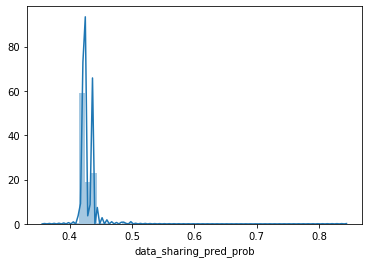

In [71]:
sns.distplot(df_pool.data_sharing_pred_prob, )

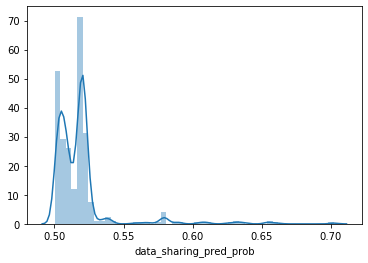

In [72]:
sns.distplot(statements_to_label.data_sharing_pred_prob)

In [94]:
df_labeled['identifier'] = df_labeled.pmcid.astype('str') + ' ' + df_labeled.context

In [95]:
df_labeled.identifier.unique().shape

(500,)

In [96]:
statements_to_label['identifier'] = statements_to_label.pmcid.astype('str') + ' ' + statements_to_label.context

In [102]:
statements_to_label = statements_to_label[['text', 'section', 'doi', 'Journal Title', 
                                           'has_url', 'has_parenth', 'repo', 'pmcid', 
                                           'context', 'paper_offset', 'kw_code', 
                                           'identifier']]
labels = df_labeled[['n2', 'Comment', 'identifier']]

In [104]:
dat = statements_to_label.set_index('identifier').join(labels.set_index('identifier'))

In [106]:
dat.reset_index(drop=True, inplace=True)
dat.shape

(500, 13)

In [107]:
dat.head()

,text,section,doi,Journal Title,has_url,has_parenth,repo,pmcid,context,paper_offset,kw_code,n2,Comment
0,of some on this list are maintained by the Neu...,INTRO,10.1016/j.neuroimage.2009.03.086,Neuroimage,True,Balanced,nitrc,2754579,of some on this list are maintained by the Neu...,17113,1,NaN,NaN
1,SNP genotype data were obtained from dbGaP (Na...,INTRO,10.1038/ng.523,Nat Genet,False,Balanced,dbgap,2854040,SNP genotype data were obtained from dbGaP (Na...,1618,0,NaN,NaN
2,More complete data sets that are currently bei...,INTRO,10.1038/nature08536,Nature,True,Balanced,brain-map.org,2884271,More complete data sets that are currently bei...,9793,0,n,NaN
3,Because Nrp2 marks the contiguous olfactory co...,RESULTS,10.1038/nn.2427,Nat Neurosci,True,Balanced,brain-map.org,2897740,Because Nrp2 marks the contiguous olfactory co...,7893,0,NaN,NaN
4,To explore for other true signals that may not...,INTRO,10.1038/ng.642,Nat Genet,False,Balanced,dbgap,2930111,To explore for other true signals that may not...,5540,0,NaN,NaN


In [110]:
labels.head()

,n2,Comment,identifier
0,2,NaN,3048805 Phenotype and geno...
1,2,NaN,3951904 This network hyperconnectivity result ...
2,2,NaN,4435707 Data were obtained from the Alzheimer'...
3,2,NaN,4851708 These disorders were all hypothesized ...
4,2,NaN,4814225 The HCP (Human Connectome Project) dat...


In [114]:
dat[dat.pmcid==3951904]

,text,section,doi,Journal Title,has_url,has_parenth,repo,pmcid,context,paper_offset,kw_code,n2,Comment
